In [55]:
import os

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 5)

from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate

In [39]:
DATA_DIR = os.path.join(os.getcwd(), 'data')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
MASK_DIR = os.path.join(DATA_DIR, 'train_masks')
TRAIN_IMAGE_LIST = os.listdir(TRAIN_DIR)
MASK_IMAGE_LIST = os.listdir(MASK_DIR)
ASPECT_RATIO = 1280 / 1918

In [40]:
def image_generator_function(batch_size, img_width = None):
    
    '''
    batch_size: The number of images to be consider in one batch.
    img_width: The width to which the original image is resized while maintaining aspect ratio. Does not resize if no parameters passed.
    '''
    
    img_dim = None
    if img_width is not None:
        img_dim = [int(ASPECT_RATIO * img_width), img_width]
    
    while True:
        random_indices = np.random.choice(len(TRAIN_IMAGE_LIST), batch_size)
        
        imgs = [img_to_array(load_img(os.path.join(TRAIN_DIR, TRAIN_IMAGE_LIST[index]), target_size = img_dim)) / 255 for index in random_indices]
        masks = [img_to_array(load_img(os.path.join(MASK_DIR, MASK_IMAGE_LIST[index]), target_size = img_dim)) / 255 for index in random_indices]

        yield np.array(imgs), np.array(masks)

In [41]:
train_generator = image_generator_function(5, 300)
img, mask = next(train_generator)

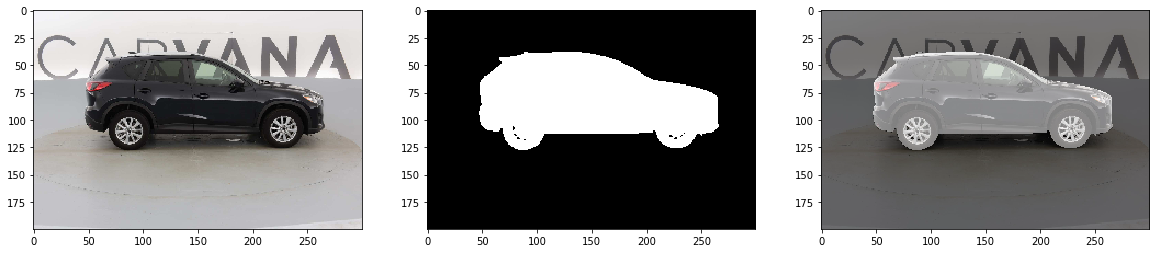

In [42]:
plt.subplot(1, 3, 1)
plt.imshow(img[0])
plt.subplot(1, 3, 2)
plt.imshow(mask[0])
plt.subplot(1, 3, 3)
plt.imshow(img[0])
plt.imshow(mask[0], alpha=0.5)
plt.show()

In [56]:
def get_unet(img_height, img_width):
    
    
    ### TODO: Fix U-Net concatenation layers
    
    inputs = Input((img_height, img_width, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = Concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [57]:
unet_model = get_unet(img[0].shape[0], img[0].shape[1])

TypeError: __init__() got multiple values for argument 'axis'